# Sample 1 - SVM Classifer

## Step.1 データの読み込み
`utils.load_data`関数を使用し， 今回使用するデータの全てを読み込みます．

In [1]:
import utils

# Load CSV
X_raw, Y_raw, cols_raw = utils.load_data(mode="all")
print("len(X_raw)={}, X_raw[0]={}, Y_raw={}".format(len(X_raw), X_raw[0].shape, Y_raw.shape))

for i,key in enumerate(cols_raw):
    print("col_row[{}] = {}".format(i, key))

len(X_raw)=631, X_raw[0]=(9360, 8), Y_raw=(631, 1)
col_row[0] = lon
col_row[1] = lat
col_row[2] = azimus
col_row[3] = elevation
col_row[4] = daytime
col_row[5] = elapsed
col_row[6] = clock
col_row[7] = days


## Step.2 軌跡の時系列データに対して特徴抽出
+ 各タイムステップに対して，　特徴抽出を行います． サンプルでは 速度と加速度， およびその差分値を計算する関数を用意しました．
+ `utils.feature_extraction_broadcast`　関数に元データ(`X_raw`)と処理関数を渡します．　また計算に使用する列はcolsで指定します．
+ 抽出した特徴は, `utils.feature_concatenate`を使って，1つの変数に結合してください.

In [2]:
# Feature Extraction from whole trajectory
X_speed, cols_speed = utils.feature_extraction_broadcast(X_raw, func=utils.get_speed_and_acc, cols=[0,1,5,])
print("X_speed[0]={}\n".format(X_speed[0].shape))

for i,key in enumerate(cols_speed):
    print("col_speed[{}] = {}".format(i, key))

X_speed[0]=(9360, 4)

col_speed[0] = speed
col_speed[1] = speed_diff
col_speed[2] = acc
col_speed[3] = acc_diff


In [3]:
# Concatenate Extracted Feature Vectors
X = utils.feature_concatenate(X_raw, X_speed)

cols = cols_raw + cols_speed
print("len(X)={}, X[0]={}\n".format(len(X), X[0].shape))

for i,key in enumerate(cols):
    print("col{:>4} = {}".format(i, key))

len(X)=631, X[0]=(9360, 12)

col   0 = lon
col   1 = lat
col   2 = azimus
col   3 = elevation
col   4 = daytime
col   5 = elapsed
col   6 = clock
col   7 = days
col   8 = speed
col   9 = speed_diff
col  10 = acc
col  11 = acc_diff


## Step.3 軌跡全体から特徴抽出 (時系列を圧縮) & Training/Test Dataへ分割
+ 時間方向に圧縮を行い， 多次元の時系列データを1つの値に圧縮します.
+ configを編集することで行えます. 特徴量の名前(col_name), 抽出対象のカラムID(col), 特徴抽出に使用する関数(aggfunc).

In [6]:
import numpy as np

config  = [
    {"col_name":"lon_mean", "col":0,"aggfunc": np.mean, },
    {"col_name":"lon_std",     "col":0,"aggfunc": np.std },
    {"col_name":"speed_mean", "col":8,"aggfunc": np.mean, },
    {"col_name":"speed_std", "col":8,"aggfunc": np.std },
]
df =  utils.feature_aggrigator(X, config,)


# Split Data
df, (X_train, Y_train), (X_test, Y_test) = utils.split_train_test(df, Y_raw, use_std=True)
print("X_train={}, Y_train={}".format(X_train.shape, Y_train.shape,))
print("X_test={}, Y_test={}".format(X_test.shape, Y_test.shape,))
display(df.head())

X_train=(500, 4), Y_train=(500,)
X_test=(131, 4), Y_test=(131,)


,lon_mean,lon_std,speed_mean,speed_std,true
0,0.485390,-0.191123,-0.545262,-0.252432,1
1,-0.054167,-0.336685,1.144472,0.993693,1
2,-0.292809,-0.605986,-1.591125,-1.818191,1
3,-0.015994,-0.567528,-0.173540,-0.886447,1
4,-0.543081,0.142169,-0.219898,0.203248,1


## Step.4 学習

In [8]:
from sklearn.svm import SVC

model = SVC()
model.fit(X_train, Y_train)
Y_pred =model.predict(X_test)


# Save Prediction Results
df_pred = df.loc[range(500,631), :].reset_index(drop=False).rename(columns={"index":"ID"})
df_pred["pred"] = Y_pred
display(df_pred.head())

,ID,lon_mean,lon_std,speed_mean,speed_std,true,pred
0,500,-0.988184,0.137444,2.156109,0.248237,1,1
1,501,-0.910996,0.104998,0.245357,0.799538,1,0
2,502,-0.040848,-0.529712,-0.337238,0.061653,1,1
3,503,0.071525,-0.513551,-0.535585,0.176832,1,1
4,504,-1.120915,0.619954,3.390169,0.946858,0,0


## Step.5 結果の確認

In [9]:
# スコアの確認
utils.scores(df_pred)

,Male,Female,All
Precision,0.730769,0.594937,0.648855
Recall,0.542857,0.770492,0.648855
F1,0.622951,0.671429,0.648855


2018-10-22 03:43:03,319 | INFO  | utils.draw_cmx | Start: Draw CMX


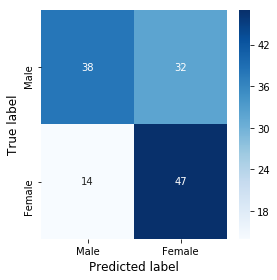

,Male,Female
Male,38,32
Female,14,47


In [10]:
import matplotlib
%matplotlib inline 

# Confution Matrix
utils.draw_cmx(df_pred)

# -----------------------------

# 結果の分析
ヒストグラムや散布図などを使って，　使用した特徴量が適切か確認します．

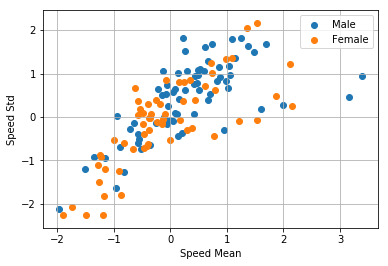

In [11]:
import matplotlib
%matplotlib inline 
import matplotlib.pyplot as plt
import seaborn as sns

df_male    = df_pred[df_pred["true"] == 0]
df_female = df_pred[df_pred["true"] == 1]

plt.figure()
plt.scatter(df_male["speed_mean"], df_male["speed_std"], label="Male")
plt.scatter(df_female["speed_mean"], df_female["speed_std"], label="Female")
plt.xlabel("Speed Mean")
plt.ylabel("Speed Std")
plt.grid()
plt.legend()
plt.show()

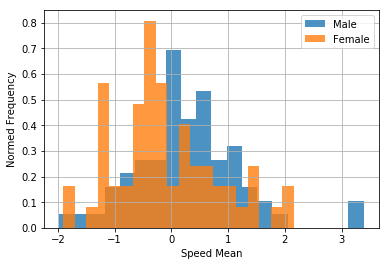

In [12]:
import matplotlib
%matplotlib inline 
import matplotlib.pyplot as plt
import seaborn as sns

df_male    = df_pred[df_pred["true"] == 0]
df_female = df_pred[df_pred["true"] == 1]

plt.figure()
plt.hist(df_male["speed_mean"], density=True, bins=20, alpha=0.8, label="Male")
plt.hist(df_female["speed_mean"], density=True, bins=20, alpha=0.8,  label="Female")
plt.ylabel("Normed Frequency")
plt.xlabel("Speed Mean")
plt.grid()
plt.legend()
plt.show()